# Importing Dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


In [4]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

     |████████████████████████████████| 403 kB 3.2 MB/s            


In [5]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

# Preprocess

In [6]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [7]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [8]:
dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined/"

In [9]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

This code just gets a list of classes

In [10]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [11]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


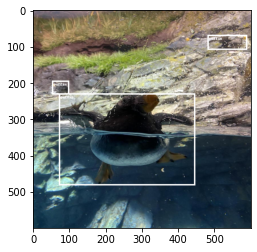

In [12]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [13]:
len(train_dataset)

447

# Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [14]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [17]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [18]:
device = torch.device("cuda") # use GPU to train

In [19]:
model = model.to(device)

In [20]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [21]:
import sys

# Training


In [22]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [23]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [00:22<00:00,  4.89it/s]


Epoch 0, lr: 0.010000, loss: 1.005050, loss_classifier: 0.482949, loss_box: 0.401534, loss_rpn_box: 0.032129, loss_object: 0.088437


100%|██████████| 112/112 [00:16<00:00,  6.79it/s]


Epoch 1, lr: 0.010000, loss: 0.766352, loss_classifier: 0.344697, loss_box: 0.332053, loss_rpn_box: 0.028323, loss_object: 0.061279


100%|██████████| 112/112 [00:15<00:00,  7.03it/s]


Epoch 2, lr: 0.010000, loss: 0.753885, loss_classifier: 0.318956, loss_box: 0.357582, loss_rpn_box: 0.026403, loss_object: 0.050944


100%|██████████| 112/112 [00:15<00:00,  7.07it/s]


Epoch 3, lr: 0.010000, loss: 0.694697, loss_classifier: 0.281215, loss_box: 0.345269, loss_rpn_box: 0.024660, loss_object: 0.043552


100%|██████████| 112/112 [00:15<00:00,  7.19it/s]


Epoch 4, lr: 0.010000, loss: 0.643753, loss_classifier: 0.249003, loss_box: 0.335750, loss_rpn_box: 0.022850, loss_object: 0.036151


100%|██████████| 112/112 [00:15<00:00,  7.31it/s]


Epoch 5, lr: 0.010000, loss: 0.655826, loss_classifier: 0.256607, loss_box: 0.340371, loss_rpn_box: 0.023799, loss_object: 0.035049


100%|██████████| 112/112 [00:15<00:00,  7.37it/s]


Epoch 6, lr: 0.010000, loss: 0.645041, loss_classifier: 0.243259, loss_box: 0.346174, loss_rpn_box: 0.022888, loss_object: 0.032720


100%|██████████| 112/112 [00:15<00:00,  7.42it/s]


Epoch 7, lr: 0.010000, loss: 0.642328, loss_classifier: 0.241807, loss_box: 0.349000, loss_rpn_box: 0.021761, loss_object: 0.029759


100%|██████████| 112/112 [00:15<00:00,  7.44it/s]


Epoch 8, lr: 0.010000, loss: 0.625069, loss_classifier: 0.231487, loss_box: 0.345426, loss_rpn_box: 0.020738, loss_object: 0.027417


100%|██████████| 112/112 [00:14<00:00,  7.55it/s]

Epoch 9, lr: 0.010000, loss: 0.625460, loss_classifier: 0.225683, loss_box: 0.353332, loss_rpn_box: 0.020759, loss_object: 0.025686


## Trying on sample Images

In [24]:
model.eval()
torch.cuda.empty_cache()

In [25]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [26]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

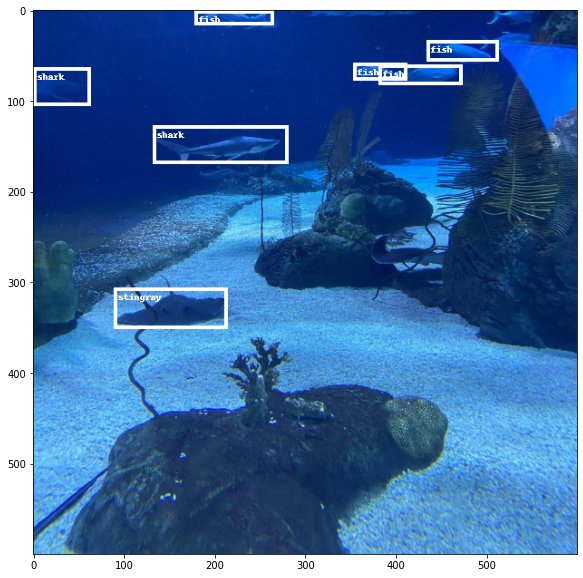

In [27]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))